# CS 679 Project
### Somayeh Fouladi, Jonathan Gallagher, William Pugsley



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import trange
import os
import torch.optim as optim
from tqdm import tqdm

## Load & Process Data

* Which dataset will we use?
* How will we load it?
* How do we convert it to a torch dataset?
* Do we want other datasets for testing?

* Use torch.fft package for Fourier transforms to discrete space

In [2]:
! pip install kaggle

In [3]:
! pip install opendatasets

In [4]:
import opendatasets as od

os.environ['KAGGLE_USERNAME'] = 'somayehfouladi'
os.environ['KAGGLE_KEY'] = '48bace1d836a02ae4b016296b6ce24a5'

In [5]:
od.download(
    "https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: somayehfouladi
Your Kaggle Key: ··········


100%|██████████| 105M/105M [00:03<00:00, 33.0MB/s]


In [6]:
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00


In [7]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryAUROC

In [8]:
# Define the paths to the directories containing your training and testing datasets
train_dataset_path = '/content/cifake-real-and-ai-generated-synthetic-images/train'
test_dataset_path = '/content/cifake-real-and-ai-generated-synthetic-images/test'

# Define the transformations to apply to the images
transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.33)), #Perform Random Resized Crop
    transforms.RandomHorizontalFlip(p=0.5), #Perform Random horizontal flip
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

In [9]:
# Create datasets for training and testing
train_dataset = ImageFolder(root=train_dataset_path, transform=transform)
test_dataset = ImageFolder(root=test_dataset_path, transform=transform)

# Create DataLoaders for training and testing datasets
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


**Test Plotting**

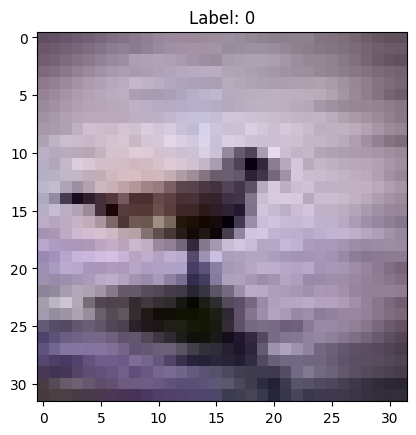

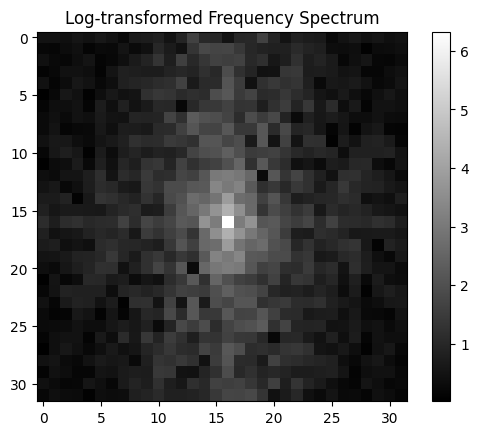

In [10]:
images, labels = next(iter(test_dataloader))

# Select the first image in the batch
image = images[2]

# denormalize to display properly
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
image = image.numpy().transpose((1, 2, 0))

# Display the image
plt.imshow(image)
plt.title(f'Label: {labels[4]}')
plt.show()

# Compute the 2D FFT of the grayscale image
gray_image = np.mean(image, axis=2)
fft_result = np.fft.fft2(gray_image)
fft_result_shifted = np.abs(np.fft.fftshift(fft_result))

# Apply logarithmic transformation
fft_log = np.log(1 + fft_result_shifted)

# Display the transformed frequency spectrum
plt.imshow(fft_log, cmap='gray')
plt.title('Log-transformed Frequency Spectrum')
plt.colorbar()
plt.show()

## Tools

In [11]:
def get_num_blocks(img_size, block_sizes):
  #returns the total number of blocks given image size and the sizes of each sequential slicing of the image

  tot = 1 #initial input image counts

  current_size = img_size
  for block_size in block_sizes:
    tot += (img_size//block_size)**2
    current_size = block_size

  return tot

In [12]:
#testing

#28x28 image split into 4 14x14, then 16 7x7
print(get_num_blocks(32, (16, 8)) == 21)

#36x36 image split into 36 6x6, then split into 36*3*3 2x2, then 36*3*3*4 1x1
print(get_num_blocks(36, (6, 2, 1)) == (1+36+36*9+36*9*4))

True
True


In [14]:
def extract_image_blocks(image_tensor, block_size):
  """
  Splits the image_tensor into sub-images of size block_size.
  Splits along the last 2 dimensions, the first 2 are batch size and channel number
  """
  N, C, W, H = image_tensor.size()

  blocks = []
  for i in range(0, W, block_size):
      for j in range(0, H, block_size):
          block = image_tensor[:, :, i:i+block_size, j:j+block_size]
          blocks.append(block)

  return blocks

**Get Flattened Size**

In [15]:
def get_flattened_size(img_size, block_sizes, channels):
    total_flattened_size = 0
    current_img_size = img_size

    for i, block_size in enumerate(block_sizes):

      num_blocks = (current_img_size // block_size) ** 2
      pooled_block_size = (block_size // 2)**2
      total_flattened_size += num_blocks * pooled_block_size * channels

      curent_img_size = block_size


    final_pooled_size = (current_img_size // 2) ** 2
    total_flattened_size += final_pooled_size * channels

    return total_flattened_size


## Define `ImageClassifier` Class

In [40]:
class ImageClassifier(nn.Module):
  """
  torch network that will classify images as AI generated or real.

  img_size:       The size of the input image
  block_sizes:    For splitting the image into blocks. The length is how many times to split the image
                      each element of the tuple tells us how big each split should be
  """
  def __init__(self, img_size, block_sizes, channels=1, initialize_weights=False):
    super().__init__()
    self.img_size = img_size #size of the input image
    self.block_sizes = block_sizes #the sizes of each subsequent splitting of the image
    self.channels = channels #the number of channels to use for the convolution layer
    self.initialize_weights = initialize_weights #whether or not to initialize the parameter weights

    self.flatten = nn.Flatten()
    self.relu = nn.LeakyReLU()

    # Calculate the flattened size for the image branch
    flattened_size = get_flattened_size(img_size, block_sizes, channels)

    #IMAGE LAYER
    ############################################
    self.img_conv_layers = [] #we want a different convolution filter for each block size (maybe even for each block?)
    #self.img_bn_layers = []  # Batch normalization layers for the image branch

    for i in range(len(block_sizes) + 1):
      #CHANGE PARAMETERS IN CONV2D
      self.img_conv_layers.append(nn.Conv2d(3, self.channels, 3, stride=1, padding=1))
      #self.img_bn_layers.append(nn.BatchNorm2d(self.channels))

    #weight initialization
    if self.initialize_weights:
      for lyr in self.img_conv_layers:
        torch.nn.init.xavier_uniform_(lyr.weight)
        torch.nn.init.zeros_(lyr.bias)

    self.img_pooling_layer = nn.AvgPool2d(2) #2x2 averaging layer (maybe use different sizes per block)

    # Extra convolutional layer after all blocks
    #self.extra_img_conv = nn.Conv2d(self.channels, self.channels * 2, 3, stride=1, padding=1)
    #self.extra_img_bn = nn.BatchNorm2d(self.channels * 2)


    self.img_FC_layer = nn.Sequential(
            nn.Dropout1d(0.5), #dropout regularization for training
            nn.Linear(flattened_size, 1000), #change sizes
            #nn.PReLU(),
            nn.PReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(1000,500),
            #nn.PReLU(),
            nn.PReLU(),
            )

    if self.initialize_weights:
      #weight initialization
      torch.nn.init.xavier_uniform_(self.img_FC_layer[1].weight)
      torch.nn.init.xavier_uniform_(self.img_FC_layer[4].weight)
      torch.nn.init.zeros_(self.img_FC_layer[1].bias)
      torch.nn.init.zeros_(self.img_FC_layer[4].bias)

    #FREQUENCY LAYER
    ############################################
    self.freq_conv_layers = [] #we want a different convolution filter for each block size (maybe even for each block?)
    #self.freq_bn_layers = []  # Batch normalization layers for the frequency branch

    for i in range(len(block_sizes) + 1):
      #CHANGE PARAMETERS IN CONV2D
      self.freq_conv_layers.append(nn.Conv2d(3, self.channels, 3, stride=1, padding=1))
      #self.freq_bn_layers.append(nn.BatchNorm2d(self.channels))

    if self.initialize_weights:
      #weight initialization
      for lyr in self.freq_conv_layers:
        torch.nn.init.xavier_uniform_(lyr.weight)
        torch.nn.init.zeros_(lyr.bias)

    self.freq_pooling_layer = nn.AvgPool2d(2) #2x2 averaging layer (maybe use different sizes per block)

    self.freq_FC_layer = nn.Sequential(
            nn.Dropout1d(0.5), #dropout regularization for training
            nn.Linear(flattened_size, 1000), #change sizes
            #nn.PReLU(),
            nn.PReLU(),
            nn.Dropout1d(0.5),
            nn.Linear(1000,500),
            #nn.PReLU(),
            nn.PReLU(),
            )

    if self.initialize_weights:
      #weight initialization
      torch.nn.init.xavier_uniform_(self.freq_FC_layer[1].weight)
      torch.nn.init.xavier_uniform_(self.freq_FC_layer[4].weight)
      torch.nn.init.zeros_(self.freq_FC_layer[1].bias)
      torch.nn.init.zeros_(self.freq_FC_layer[4].bias)

    #combine both branches
    self.combination_layer = nn.Sequential(
        nn.Dropout1d(0.5),
        nn.Linear(1000, 500),  # Change the input size to match the concatenated output size
        #nn.PReLU(),
        nn.PReLU(),
        nn.Dropout1d(0.5),
        nn.Linear(500, 1),
        nn.Sigmoid()         # Sigmoid activation to get probabilities
    )

    if self.initialize_weights:
      #weight initialization
      torch.nn.init.xavier_uniform_(self.combination_layer[1].weight)
      torch.nn.init.xavier_uniform_(self.combination_layer[4].weight)
      torch.nn.init.zeros_(self.combination_layer[1].bias)
      torch.nn.init.zeros_(self.combination_layer[4].bias)



  def get_image_blocks(self, X):
    #splits image into sub-blocks
    image_blocks = [X] #all the blocks for the image
    blocks_counts = [1] #the number of blocks at each size

    num_blocks = 0 #the number of blocks currently constructed as we iterate
    for block_size in self.block_sizes:
      new_blocks = [] #the new sub-blocks we've split

      for block in image_blocks[num_blocks:]: #only iterate over the last layer of sub-blocks
        #slice up this block into sub-blocks
        new_blocks = new_blocks + extract_image_blocks(block, block_size)

      #update iterating variable
      num_blocks = len(image_blocks)

      #save sub-blocks
      image_blocks = image_blocks + new_blocks

      #save the number of blocks at the current size
      blocks_counts.append(len(new_blocks))

    return image_blocks, blocks_counts


  def image_layer(self, image_blocks, blocks_counts):
    #the branch to handle the raw image input
    outputs = []

    #the current convolution layer we're using
    idx = 0
    #the number of blocks we've applied the convolution to
    count = 0
    #we apply the first conv layer to the whole image
    #then the next layer to the first set of slices
    #then the third layer to the second set of slices
    #and so on...

    #debugging
    #print(f"There are {len(image_blocks)} blocks to iterate through")
    #blah = 0

    for block in image_blocks: #apply operations to each block independently

      #MAYBE CHANGE ORDER OF OPERATIONS

      #convolution
      out = self.img_conv_layers[idx](block)

      #batch norm layer ??
      #out = self.img_bn_layers[idx](out)

      #activation function
      out = self.relu(out)

      #pooling layer
      out = self.img_pooling_layer(out)

      #flatten the output
      outputs.append(self.flatten(out))

      count += 1
      if count == blocks_counts[idx]: #we've applied this conv layer to all corresponding blocks
        idx += 1
        count = 0

    # Concatenate the outputs from all blocks
    flattened_output = torch.cat(outputs, dim=-1)

    # Pass through fully connected layer
    return self.img_FC_layer(flattened_output)

  def frequency_layer(self, image_blocks, blocks_counts):
    # The branch to handle the DFT of the input
    outputs = []

    #the current convolution layer we're using
    idx = 0
    #the number of blocks we've applied the convolution to
    count = 0
    #we apply the first conv layer to the whole image
    #then the next layer to the first set of slices
    #then the third layer to the second set of slices
    #and so on...

    for block in image_blocks:  # Apply operations to each block independently
        #First convert the image to grayscale
        #block = torch.mean(block, dim=1, keepdim=True)
        # Apply DFT and take magnitude
        block_dft = torch.fft.fft2(block)
        block_magnitude = torch.abs(block_dft)

        # Apply logarithmic transformation
        block_log_magnitude = torch.log(1 + block_magnitude)

        # Frequency pooling (max pool, average pool, etc.)
        out = self.freq_pooling_layer(block_log_magnitude)

        # Frequency filtering (convolution)
        out = self.freq_conv_layers[idx](out)

        #batch norm layer ??
        #out = self.freq_bn_layers[idx](out)

        # Activation function
        out = self.relu(out)

        # Flatten the output
        outputs.append(self.flatten(out))

        count += 1
        if count == blocks_counts[idx]: #we've applied this conv layer to all corresponding blocks
          idx += 1
          count = 0

    # Concatenate the outputs from all blocks
    flattened_output = torch.cat(outputs, dim=-1)

    # Pass through fully connected layer
    return self.freq_FC_layer(flattened_output)


  def forward(self, X):
    """ (tensor, tensor) -> (tensor)
    inputs:
      X: raw image
      F: image frequency decomposition

    outputs:
      probability that the image is AI generated
    """
    image_blocks, blocks_counts = self.get_image_blocks(X)
    #print(f"Block counts: {blocks_counts}")
    #print(f"Number of image blocks: {len(image_blocks)}")
    #print(f"Number of convolutional layers: {len(self.img_conv_layers)}")
    X_processed = self.image_layer(image_blocks, blocks_counts)
    F_processed = self.frequency_layer(image_blocks, blocks_counts)

    #combine outputs
    Z = torch.cat((X_processed, F_processed), dim=-1) #contcatenate, average, etc.

    return self.combination_layer(Z)


  def train_(self, dl, loss_func, optim, scheduler, epochs, val_dataloader, ver=1):
    """
    dl:           Dataloader object containing the training set
    loss_func:    The loss_function to use
    optim:        The optimizer to use
    scheduler:    Learning rate scheduler
    epochs:       How many epochs to train for
    #ver:          After every ver epochs, print a message with the total epochs passed
    """
    losses = []
    acc = []
    val_losses = []
    val_acc = []
    #store the smallest and largest gradients (in magnitude) to check for vanishing/exploding gradients
    #min_grads = []
    #max_grads = []

    self.train() #set to training mode

    for e in tqdm(range(epochs)):
      total_loss = 0 #loss for this epoch
      for batch_num, (X, target) in enumerate(dl): #we might have to change this depending on how we handle the frequency inputs
        target = target.unsqueeze(1).float() #Changes made to appease the compiler

        prediction = self(X) #run the model
        loss = loss_func(prediction, target)

        if batch_num%50 == 0: #only print every 50 batches
          print(f"Epoch {e + 1}, Batch {batch_num + 1}/{len(dl)}: Loss = {loss.item()}")

        total_loss += loss.item()

        loss.backward() #backpropagation

        """
        #exploding/vanishing gradients
        norms = []
        for p in model.parameters():
          norms.append(p.norm().item())
        min_grads.append(min(norms))
        max_grads.append(max(norms))
        """

        optim.step() #update the weights
        optim.zero_grad() #zero the gradients

        #save performance
        losses.append(loss.item())
        acc.append((torch.round(prediction) == target).float().sum().item()/X.shape[0])

      scheduler.step()
      average_loss = total_loss / len(dl)
      print(f"Epoch {e + 1}/{epochs},: Loss = {average_loss}")

      # Call the test method at the end of each epoch
      test_loss, test_accuracy, _, _, _, _= self.test(val_dataloader, loss_func)
      val_losses.append(test_loss)
      val_acc.append(test_accuracy)
      print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    #return losses, min_grads, max_grads
    return losses, acc, val_losses, val_acc


  def test(self, dl, loss_func):
    """
    dl:           Dataloader object containing the test set
    loss_func:    The loss_function to use

    Returns the loss and the accuracy on the test set.
    """
    self.eval()

    acc = BinaryAccuracy()
    precision = BinaryPrecision()
    recall = BinaryRecall()
    F1 = BinaryF1Score()
    au_roc = BinaryAUROC()

    #size = len(dl.dataset) #the number of datapoints
    num_batches = len(dl) #the number of batches

    tot_loss = 0 #the total loss across the entire dataset
    #correct = 0 #the number of correct predictions

    with torch.no_grad(): #don't do backpropagation
      for batch_num, (X, target) in enumerate(dl):
        prediction = self(X).squeeze().float()

        batch_loss = loss_func(prediction, target.float()) #the loss for this batch
        tot_loss += batch_loss.item()

        #what is the accuracy on this batch?
        #this will work if the target is in {0,1} (WE MIGHT NEED TO CHANGE THIS)
        #correct += (torch.round(prediction) == target).float().sum().item()

        #update metrics
        acc.update(prediction, target)
        precision.update(prediction, target)
        recall.update(prediction, target)
        F1.update(prediction, target)
        au_roc.update(prediction, target)

      tot_loss = tot_loss/num_batches #properly average the loss
      #correct = correct/size #return acccuracy as a fraction
    return tot_loss, acc.compute(), precision.compute(), recall.compute(), F1.compute(), au_roc.compute()

## Training

In [41]:
model = ImageClassifier(img_size=32, block_sizes=[16], channels=6, initialize_weights=True)
criterion = nn.BCELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), weight_decay=0)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10], gamma=0.1)
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0)

# Train the model
#losses, min_grads, max_grads = model.train_(train_dataloader, criterion, optimizer, epochs=2)
epochs = 15
losses, acc, val_losses, val_acc = model.train_(train_dataloader, criterion, optimizer, scheduler, epochs, test_dataloader)

# Save the trained model
torch.save(model.state_dict(), 'image_classifier.pth')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1, Batch 1/3125: Loss = 0.6876755952835083
Epoch 1, Batch 51/3125: Loss = 4.041104316711426
Epoch 1, Batch 101/3125: Loss = 3.7596330642700195
Epoch 1, Batch 151/3125: Loss = 0.5868880748748779
Epoch 1, Batch 201/3125: Loss = 0.9910997152328491
Epoch 1, Batch 251/3125: Loss = 3.7320122718811035
Epoch 1, Batch 301/3125: Loss = 3.7757396697998047
Epoch 1, Batch 351/3125: Loss = 10.021987915039062
Epoch 1, Batch 401/3125: Loss = 3.7435574531555176
Epoch 1, Batch 451/3125: Loss = 0.6145066022872925
Epoch 1, Batch 501/3125: Loss = 0.9669067859649658
Epoch 1, Batch 551/3125: Loss = 3.7743446826934814
Epoch 1, Batch 601/3125: Loss = 0.6500994563102722
Epoch 1, Batch 651/3125: Loss = 6.8788371086120605
Epoch 1, Batch 701/3125: Loss = 3.775813579559326
Epoch 1, Batch 751/3125: Loss = 4.006280899047852
Epoch 1, Batch 801/3125: Loss = 0.5858361721038818
Epoch 1, Batch 851/3125: Loss = 9.960821151733398
Epoch 1, Batch 901/3125: Loss = 6.859968185424805
Epoch 1, Batch 951/3125: Loss = 0.74944

  7%|▋         | 1/15 [09:05<2:07:11, 545.09s/it]

Test Loss: 4.883191456081185, Test Accuracy: 0.5
Epoch 2, Batch 1/3125: Loss = 6.977038383483887
Epoch 2, Batch 51/3125: Loss = 0.5226579904556274
Epoch 2, Batch 101/3125: Loss = 0.8589551448822021
Epoch 2, Batch 151/3125: Loss = 0.27395716309547424
Epoch 2, Batch 201/3125: Loss = 0.37881144881248474
Epoch 2, Batch 251/3125: Loss = 0.21853257715702057
Epoch 2, Batch 301/3125: Loss = 0.2695740759372711
Epoch 2, Batch 351/3125: Loss = 0.32702168822288513
Epoch 2, Batch 401/3125: Loss = 0.39853760600090027
Epoch 2, Batch 451/3125: Loss = 0.2311074584722519
Epoch 2, Batch 501/3125: Loss = 0.3420218229293823
Epoch 2, Batch 551/3125: Loss = 0.3645585775375366
Epoch 2, Batch 601/3125: Loss = 0.27597901225090027
Epoch 2, Batch 651/3125: Loss = 0.4090423285961151
Epoch 2, Batch 701/3125: Loss = 0.3488321006298065
Epoch 2, Batch 751/3125: Loss = 0.3934328258037567
Epoch 2, Batch 801/3125: Loss = 0.27500367164611816
Epoch 2, Batch 851/3125: Loss = 0.1504150778055191
Epoch 2, Batch 901/3125: Loss 

 13%|█▎        | 2/15 [16:24<1:44:40, 483.10s/it]

Test Loss: 0.24842928724884986, Test Accuracy: 0.8983500003814697
Epoch 3, Batch 1/3125: Loss = 0.23129351437091827
Epoch 3, Batch 51/3125: Loss = 0.10177145153284073
Epoch 3, Batch 101/3125: Loss = 0.2812686860561371
Epoch 3, Batch 151/3125: Loss = 0.27440178394317627
Epoch 3, Batch 201/3125: Loss = 0.20522184669971466
Epoch 3, Batch 251/3125: Loss = 0.22181256115436554
Epoch 3, Batch 301/3125: Loss = 0.2965334355831146
Epoch 3, Batch 351/3125: Loss = 0.25212761759757996
Epoch 3, Batch 401/3125: Loss = 0.1520470231771469
Epoch 3, Batch 451/3125: Loss = 0.19635362923145294
Epoch 3, Batch 501/3125: Loss = 0.3215200901031494
Epoch 3, Batch 551/3125: Loss = 0.13158513605594635
Epoch 3, Batch 601/3125: Loss = 0.5653350353240967
Epoch 3, Batch 651/3125: Loss = 0.2697490155696869
Epoch 3, Batch 701/3125: Loss = 0.209600031375885
Epoch 3, Batch 751/3125: Loss = 0.18295562267303467
Epoch 3, Batch 801/3125: Loss = 0.18084001541137695
Epoch 3, Batch 851/3125: Loss = 0.3226891756057739
Epoch 3, B

 20%|██        | 3/15 [23:45<1:32:44, 463.73s/it]

Test Loss: 0.20821187727451324, Test Accuracy: 0.916700005531311
Epoch 4, Batch 1/3125: Loss = 0.09385835379362106
Epoch 4, Batch 51/3125: Loss = 0.44085749983787537
Epoch 4, Batch 101/3125: Loss = 0.3854377269744873
Epoch 4, Batch 151/3125: Loss = 0.1845371127128601
Epoch 4, Batch 201/3125: Loss = 0.20052148401737213
Epoch 4, Batch 251/3125: Loss = 0.26143303513526917
Epoch 4, Batch 301/3125: Loss = 0.31560981273651123
Epoch 4, Batch 351/3125: Loss = 0.16682681441307068
Epoch 4, Batch 401/3125: Loss = 0.2117602825164795
Epoch 4, Batch 451/3125: Loss = 0.17525088787078857
Epoch 4, Batch 501/3125: Loss = 0.25293663144111633
Epoch 4, Batch 551/3125: Loss = 0.3248842656612396
Epoch 4, Batch 601/3125: Loss = 0.23548686504364014
Epoch 4, Batch 651/3125: Loss = 0.17605920135974884
Epoch 4, Batch 701/3125: Loss = 0.19496925175189972
Epoch 4, Batch 751/3125: Loss = 0.04218294098973274
Epoch 4, Batch 801/3125: Loss = 0.0843144953250885
Epoch 4, Batch 851/3125: Loss = 0.1535194367170334
Epoch 4,

 27%|██▋       | 4/15 [31:01<1:23:00, 452.76s/it]

Test Loss: 0.20588677773177624, Test Accuracy: 0.9153500199317932
Epoch 5, Batch 1/3125: Loss = 0.27753108739852905
Epoch 5, Batch 51/3125: Loss = 0.20266681909561157
Epoch 5, Batch 101/3125: Loss = 0.22142115235328674
Epoch 5, Batch 151/3125: Loss = 0.08393917977809906
Epoch 5, Batch 201/3125: Loss = 0.16507349908351898
Epoch 5, Batch 251/3125: Loss = 0.18546108901500702
Epoch 5, Batch 301/3125: Loss = 0.08266714960336685
Epoch 5, Batch 351/3125: Loss = 0.039015211164951324
Epoch 5, Batch 401/3125: Loss = 0.1156085729598999
Epoch 5, Batch 451/3125: Loss = 0.24773083627223969
Epoch 5, Batch 501/3125: Loss = 0.13224577903747559
Epoch 5, Batch 551/3125: Loss = 0.20624125003814697
Epoch 5, Batch 601/3125: Loss = 0.3027474284172058
Epoch 5, Batch 651/3125: Loss = 0.18169379234313965
Epoch 5, Batch 701/3125: Loss = 0.05865776166319847
Epoch 5, Batch 751/3125: Loss = 0.10032035410404205
Epoch 5, Batch 801/3125: Loss = 0.20350567996501923
Epoch 5, Batch 851/3125: Loss = 0.10549750924110413
Ep

 33%|███▎      | 5/15 [38:18<1:14:29, 446.93s/it]

Test Loss: 0.17987933754622937, Test Accuracy: 0.9266999959945679
Epoch 6, Batch 1/3125: Loss = 0.08572996407747269
Epoch 6, Batch 51/3125: Loss = 0.15999510884284973
Epoch 6, Batch 101/3125: Loss = 0.11650398373603821
Epoch 6, Batch 151/3125: Loss = 0.19854161143302917
Epoch 6, Batch 201/3125: Loss = 0.21607190370559692
Epoch 6, Batch 251/3125: Loss = 0.2336297333240509
Epoch 6, Batch 301/3125: Loss = 0.06145558878779411
Epoch 6, Batch 351/3125: Loss = 0.2527633607387543
Epoch 6, Batch 401/3125: Loss = 0.15933458507061005
Epoch 6, Batch 451/3125: Loss = 0.22463400661945343
Epoch 6, Batch 501/3125: Loss = 0.32673346996307373
Epoch 6, Batch 551/3125: Loss = 0.12978455424308777
Epoch 6, Batch 601/3125: Loss = 0.10495255887508392
Epoch 6, Batch 651/3125: Loss = 0.1741851419210434
Epoch 6, Batch 701/3125: Loss = 0.20013751089572906
Epoch 6, Batch 751/3125: Loss = 0.08357812464237213
Epoch 6, Batch 801/3125: Loss = 0.3179762363433838
Epoch 6, Batch 851/3125: Loss = 0.2304866909980774
Epoch 

 40%|████      | 6/15 [45:37<1:06:39, 444.40s/it]

Test Loss: 0.19156906955838204, Test Accuracy: 0.9225000143051147
Epoch 7, Batch 1/3125: Loss = 0.19217205047607422
Epoch 7, Batch 51/3125: Loss = 0.05656439810991287
Epoch 7, Batch 101/3125: Loss = 0.036590781062841415
Epoch 7, Batch 151/3125: Loss = 0.1068057268857956
Epoch 7, Batch 201/3125: Loss = 0.25590962171554565
Epoch 7, Batch 251/3125: Loss = 0.07721593230962753
Epoch 7, Batch 301/3125: Loss = 0.09209682047367096
Epoch 7, Batch 351/3125: Loss = 0.15760543942451477
Epoch 7, Batch 401/3125: Loss = 0.16268129646778107
Epoch 7, Batch 451/3125: Loss = 0.22366775572299957
Epoch 7, Batch 501/3125: Loss = 0.07597140222787857
Epoch 7, Batch 551/3125: Loss = 0.1283574253320694
Epoch 7, Batch 601/3125: Loss = 0.06726598739624023
Epoch 7, Batch 651/3125: Loss = 0.11934646219015121
Epoch 7, Batch 701/3125: Loss = 0.2666681706905365
Epoch 7, Batch 751/3125: Loss = 0.2251325249671936
Epoch 7, Batch 801/3125: Loss = 0.15959776937961578
Epoch 7, Batch 851/3125: Loss = 0.11542180180549622
Epoc

 47%|████▋     | 7/15 [52:59<59:08, 443.56s/it]  

Test Loss: 0.1788462411224842, Test Accuracy: 0.9284999966621399
Epoch 8, Batch 1/3125: Loss = 0.18177521228790283
Epoch 8, Batch 51/3125: Loss = 0.04639206826686859
Epoch 8, Batch 101/3125: Loss = 0.12999027967453003
Epoch 8, Batch 151/3125: Loss = 0.1589963138103485
Epoch 8, Batch 201/3125: Loss = 0.10781620442867279
Epoch 8, Batch 251/3125: Loss = 0.27904897928237915
Epoch 8, Batch 301/3125: Loss = 0.040764566510915756
Epoch 8, Batch 351/3125: Loss = 0.059064388275146484
Epoch 8, Batch 401/3125: Loss = 0.26538586616516113
Epoch 8, Batch 451/3125: Loss = 0.32319071888923645
Epoch 8, Batch 501/3125: Loss = 0.2154598981142044
Epoch 8, Batch 551/3125: Loss = 0.14027899503707886
Epoch 8, Batch 601/3125: Loss = 0.030690494924783707
Epoch 8, Batch 651/3125: Loss = 0.04279661178588867
Epoch 8, Batch 701/3125: Loss = 0.0700397714972496
Epoch 8, Batch 751/3125: Loss = 0.06582245230674744
Epoch 8, Batch 801/3125: Loss = 0.09429693222045898
Epoch 8, Batch 851/3125: Loss = 0.20752912759780884
Ep

 53%|█████▎    | 8/15 [1:00:18<51:35, 442.24s/it]

Test Loss: 0.1965285047739744, Test Accuracy: 0.9208999872207642
Epoch 9, Batch 1/3125: Loss = 0.09408766031265259
Epoch 9, Batch 51/3125: Loss = 0.07530640810728073
Epoch 9, Batch 101/3125: Loss = 0.2138252556324005
Epoch 9, Batch 151/3125: Loss = 0.03588500991463661
Epoch 9, Batch 201/3125: Loss = 0.23779568076133728
Epoch 9, Batch 251/3125: Loss = 0.1539420485496521
Epoch 9, Batch 301/3125: Loss = 0.33450472354888916
Epoch 9, Batch 351/3125: Loss = 0.07623002678155899
Epoch 9, Batch 401/3125: Loss = 0.29985252022743225
Epoch 9, Batch 451/3125: Loss = 0.12728627026081085
Epoch 9, Batch 501/3125: Loss = 0.0571051761507988
Epoch 9, Batch 551/3125: Loss = 0.18952053785324097
Epoch 9, Batch 601/3125: Loss = 0.22108608484268188
Epoch 9, Batch 651/3125: Loss = 0.15808142721652985
Epoch 9, Batch 701/3125: Loss = 0.17394085228443146
Epoch 9, Batch 751/3125: Loss = 0.024599798023700714
Epoch 9, Batch 801/3125: Loss = 0.18899130821228027
Epoch 9, Batch 851/3125: Loss = 0.24835246801376343
Epoc

 60%|██████    | 9/15 [1:07:39<44:09, 441.63s/it]

Test Loss: 0.17473888332396745, Test Accuracy: 0.9309499859809875
Epoch 10, Batch 1/3125: Loss = 0.03295579552650452
Epoch 10, Batch 51/3125: Loss = 0.02894306741654873
Epoch 10, Batch 101/3125: Loss = 0.10196975618600845
Epoch 10, Batch 151/3125: Loss = 0.14766237139701843
Epoch 10, Batch 201/3125: Loss = 0.09822074323892593
Epoch 10, Batch 251/3125: Loss = 0.17825528979301453
Epoch 10, Batch 301/3125: Loss = 0.16658398509025574
Epoch 10, Batch 351/3125: Loss = 0.15587015450000763
Epoch 10, Batch 401/3125: Loss = 0.36391210556030273
Epoch 10, Batch 451/3125: Loss = 0.04302327707409859
Epoch 10, Batch 501/3125: Loss = 0.18254733085632324
Epoch 10, Batch 551/3125: Loss = 0.2269737720489502
Epoch 10, Batch 601/3125: Loss = 0.06884347647428513
Epoch 10, Batch 651/3125: Loss = 0.14937245845794678
Epoch 10, Batch 701/3125: Loss = 0.2109842151403427
Epoch 10, Batch 751/3125: Loss = 0.1554138958454132
Epoch 10, Batch 801/3125: Loss = 0.28126561641693115
Epoch 10, Batch 851/3125: Loss = 0.0830

 67%|██████▋   | 10/15 [1:14:59<36:45, 441.13s/it]

Test Loss: 0.17555201586186886, Test Accuracy: 0.9312499761581421
Epoch 11, Batch 1/3125: Loss = 0.08890185505151749
Epoch 11, Batch 51/3125: Loss = 0.1335480511188507
Epoch 11, Batch 101/3125: Loss = 0.06333982944488525
Epoch 11, Batch 151/3125: Loss = 0.12438961863517761
Epoch 11, Batch 201/3125: Loss = 0.24190950393676758
Epoch 11, Batch 251/3125: Loss = 0.05198249965906143
Epoch 11, Batch 301/3125: Loss = 0.22354696691036224
Epoch 11, Batch 351/3125: Loss = 0.048117589205503464
Epoch 11, Batch 401/3125: Loss = 0.12302446365356445
Epoch 11, Batch 451/3125: Loss = 0.028065400198101997
Epoch 11, Batch 501/3125: Loss = 0.06715061515569687
Epoch 11, Batch 551/3125: Loss = 0.03383837267756462
Epoch 11, Batch 601/3125: Loss = 0.03817509487271309
Epoch 11, Batch 651/3125: Loss = 0.025243228301405907
Epoch 11, Batch 701/3125: Loss = 0.08010745048522949
Epoch 11, Batch 751/3125: Loss = 0.021355396136641502
Epoch 11, Batch 801/3125: Loss = 0.3058620095252991
Epoch 11, Batch 851/3125: Loss = 0

 73%|███████▎  | 11/15 [1:22:19<29:23, 440.98s/it]

Test Loss: 0.1574022716358304, Test Accuracy: 0.9399499893188477
Epoch 12, Batch 1/3125: Loss = 0.12967689335346222
Epoch 12, Batch 51/3125: Loss = 0.004454737529158592
Epoch 12, Batch 101/3125: Loss = 0.3237544894218445
Epoch 12, Batch 151/3125: Loss = 0.07424533367156982
Epoch 12, Batch 201/3125: Loss = 0.22086583077907562
Epoch 12, Batch 251/3125: Loss = 0.08304302394390106
Epoch 12, Batch 301/3125: Loss = 0.0334077924489975
Epoch 12, Batch 351/3125: Loss = 0.04097659885883331
Epoch 12, Batch 401/3125: Loss = 0.1529148519039154
Epoch 12, Batch 451/3125: Loss = 0.08612482994794846
Epoch 12, Batch 501/3125: Loss = 0.027095021679997444
Epoch 12, Batch 551/3125: Loss = 0.0164320170879364
Epoch 12, Batch 601/3125: Loss = 0.2762472331523895
Epoch 12, Batch 651/3125: Loss = 0.28217339515686035
Epoch 12, Batch 701/3125: Loss = 0.09542074054479599
Epoch 12, Batch 751/3125: Loss = 0.07285857200622559
Epoch 12, Batch 801/3125: Loss = 0.06449602544307709
Epoch 12, Batch 851/3125: Loss = 0.03498

 80%|████████  | 12/15 [1:29:39<22:01, 440.65s/it]

Test Loss: 0.15741620861813427, Test Accuracy: 0.9399999976158142
Epoch 13, Batch 1/3125: Loss = 0.0934489369392395
Epoch 13, Batch 51/3125: Loss = 0.033078633248806
Epoch 13, Batch 101/3125: Loss = 0.10075962543487549
Epoch 13, Batch 151/3125: Loss = 0.0751400887966156
Epoch 13, Batch 201/3125: Loss = 0.27194416522979736
Epoch 13, Batch 251/3125: Loss = 0.20070138573646545
Epoch 13, Batch 301/3125: Loss = 0.03282842040061951
Epoch 13, Batch 351/3125: Loss = 0.14532965421676636
Epoch 13, Batch 401/3125: Loss = 0.09998465329408646
Epoch 13, Batch 451/3125: Loss = 0.07640378922224045
Epoch 13, Batch 501/3125: Loss = 0.08794476091861725
Epoch 13, Batch 551/3125: Loss = 0.1647072583436966
Epoch 13, Batch 601/3125: Loss = 0.018662534654140472
Epoch 13, Batch 651/3125: Loss = 0.020694943144917488
Epoch 13, Batch 701/3125: Loss = 0.02320149727165699
Epoch 13, Batch 751/3125: Loss = 0.06928114593029022
Epoch 13, Batch 801/3125: Loss = 0.08236733824014664
Epoch 13, Batch 851/3125: Loss = 0.0699

 87%|████████▋ | 13/15 [1:36:58<14:40, 440.03s/it]

Test Loss: 0.1572555604748428, Test Accuracy: 0.9409499764442444
Epoch 14, Batch 1/3125: Loss = 0.017710313200950623
Epoch 14, Batch 51/3125: Loss = 0.05836286395788193
Epoch 14, Batch 101/3125: Loss = 0.02294255793094635
Epoch 14, Batch 151/3125: Loss = 0.010266439989209175
Epoch 14, Batch 201/3125: Loss = 0.059145547449588776
Epoch 14, Batch 251/3125: Loss = 0.048180148005485535
Epoch 14, Batch 301/3125: Loss = 0.02082078903913498
Epoch 14, Batch 351/3125: Loss = 0.02799225226044655
Epoch 14, Batch 401/3125: Loss = 0.12414392083883286
Epoch 14, Batch 451/3125: Loss = 0.07896173000335693
Epoch 14, Batch 501/3125: Loss = 0.021338701248168945
Epoch 14, Batch 551/3125: Loss = 0.038623832166194916
Epoch 14, Batch 601/3125: Loss = 0.0853588730096817
Epoch 14, Batch 651/3125: Loss = 0.1266900599002838
Epoch 14, Batch 701/3125: Loss = 0.07997921854257584
Epoch 14, Batch 751/3125: Loss = 0.06624811142683029
Epoch 14, Batch 801/3125: Loss = 0.09018568694591522
Epoch 14, Batch 851/3125: Loss = 

 93%|█████████▎| 14/15 [1:44:13<07:18, 438.58s/it]

Test Loss: 0.15762877545431256, Test Accuracy: 0.9401000142097473
Epoch 15, Batch 1/3125: Loss = 0.00869972538203001
Epoch 15, Batch 51/3125: Loss = 0.23938298225402832
Epoch 15, Batch 101/3125: Loss = 0.13770925998687744
Epoch 15, Batch 151/3125: Loss = 0.07621690630912781
Epoch 15, Batch 201/3125: Loss = 0.13324306905269623
Epoch 15, Batch 251/3125: Loss = 0.13512389361858368
Epoch 15, Batch 301/3125: Loss = 0.0966431200504303
Epoch 15, Batch 351/3125: Loss = 0.04287860170006752
Epoch 15, Batch 401/3125: Loss = 0.05006135627627373
Epoch 15, Batch 451/3125: Loss = 0.04705505073070526
Epoch 15, Batch 501/3125: Loss = 0.04454444348812103
Epoch 15, Batch 551/3125: Loss = 0.0603012777864933
Epoch 15, Batch 601/3125: Loss = 0.06945470720529556
Epoch 15, Batch 651/3125: Loss = 0.08143987506628036
Epoch 15, Batch 701/3125: Loss = 0.0303703211247921
Epoch 15, Batch 751/3125: Loss = 0.17693999409675598
Epoch 15, Batch 801/3125: Loss = 0.0034040638711303473
Epoch 15, Batch 851/3125: Loss = 0.14

100%|██████████| 15/15 [1:51:29<00:00, 445.94s/it]

Test Loss: 0.16016359365992247, Test Accuracy: 0.9401999711990356


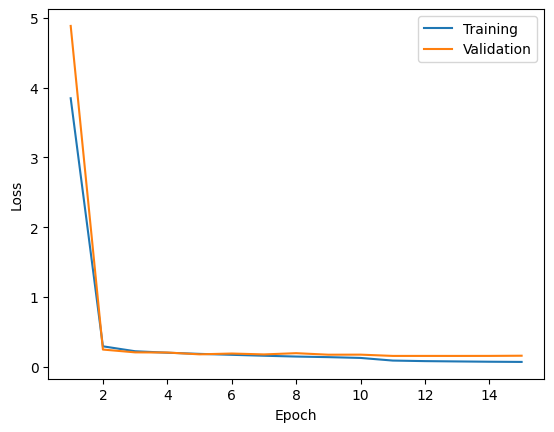

In [43]:
wind_size = len(train_dataloader) #number of batches
epoch_losses = [sum(losses[i*wind_size:(i+1)*wind_size])/len(losses[i*wind_size:(i+1)*wind_size]) for i in range(epochs)]

plt.figure()
plt.plot(list(range(1, len(epoch_losses)+1)), epoch_losses, label="Training")
plt.plot(list(range(1, len(val_losses)+1)), val_losses, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

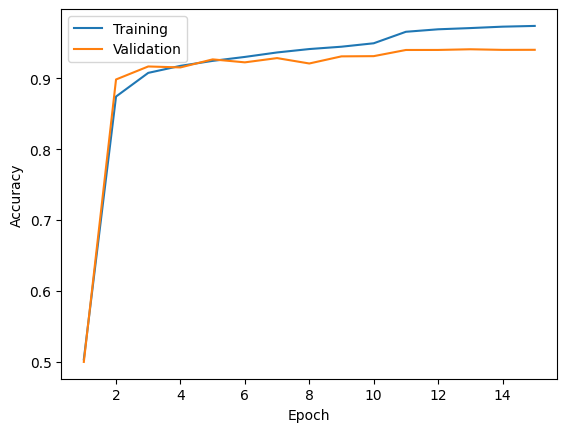

In [44]:
wind_size = len(train_dataloader) #number of batches
epoch_acc = [sum(acc[i*wind_size:(i+1)*wind_size])/len(acc[i*wind_size:(i+1)*wind_size]) for i in range(epochs)]

plt.figure()
plt.plot(list(range(1, len(epoch_acc)+1)), epoch_acc, label="Training")
plt.plot(list(range(1, len(val_acc)+1)), val_acc, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [45]:
def moving_average(arr, window_size):
  i = 0
  # Initialize an empty list to store moving averages
  moving_averages = []

  # Loop through the array t o
  #consider every window of size 3
  while i < len(arr) - window_size + 1:

    # Calculate the average of current window
    window_average = round(np.sum(arr[
      i:i+window_size]) / window_size, 2)

    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)

    # Shift window to right by one position
    i += 1

  return moving_averages

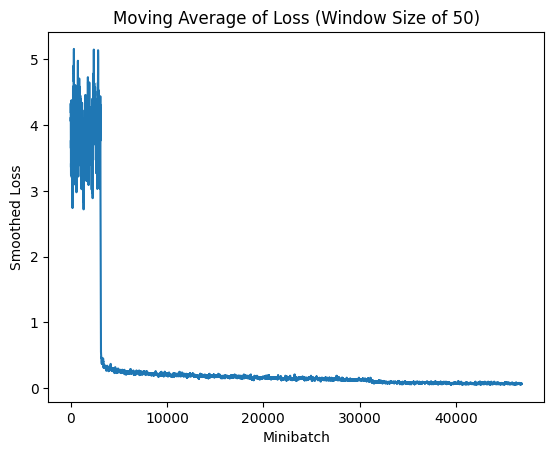

In [46]:
plt.figure()
window_size = 50
plt.plot(moving_average(losses, window_size))
plt.xlabel("Minibatch")
plt.ylabel("Smoothed Loss")
plt.title(f"Moving Average of Loss (Window Size of {window_size})")
plt.show()

In [47]:
test_loss, test_acc, test_precision, test_recall, test_F1, test_au_roc= model.test(test_dataloader, criterion)
print(f"Test accuracy: {test_acc}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1 score: {test_F1}")
print(f"Test loss: {test_loss}")
print(f"Test AU-ROC: {test_au_roc}")

Test accuracy: 0.9406999945640564
Test precision: 0.9351303577423096
Test recall: 0.9470999836921692
Test F1 score: 0.9410771727561951
Test loss: 0.16003971764072775
Test AU-ROC: 0.98681757


In [48]:
train_loss, train_acc, train_precision, train_recall, train_F1, train_au_roc = model.test(train_dataloader, criterion)
print(f"train accuracy: {train_acc}")
print(f"train precision: {train_precision}")
print(f"train recall: {train_recall}")
print(f"train F1 score: {train_F1}")
print(f"train loss: {train_loss}")
print(f"train AU-ROC: {train_au_roc}")

train accuracy: 0.9749199748039246
train precision: 0.9688993096351624
train recall: 0.9813399910926819
train F1 score: 0.9750799536705017
train loss: 0.06779778867010028
train AU-ROC: 0.9972121108
